In [1]:
"""
Everything is same. But I am using the output directory of sextractor for the analysis
"""
import os
import sys
import time
import collections
import numpy as np
import cPickle as pickle
import re

#sys.path.append('/project/marcotte/jagannath/projectfiles/proteomics_single_molecule/imageAnalysis')
#sys.path.append('/home/jaggu/marcotte_project/current/project/jagannath/projectfiles/proteomics_single_molecule/imageAnalysis')
#from commonFunctions import locate,makeDir

"""
CHANNEL,FIELD,H,W,CATEGORY,FRAME 0,FRAME 1,FRAME 2,FRAME 3,FRAME 4,FRAME 5,FRAME 6,FRAME 7
ch1,0,438.1,165.05,"(False, True, True, False, True, False, False,True)",4186.5,22855.0,20894.0,13362.5,17673.0,-1219.5,2956.5,19083.0
"""

outputDir = '/home/jaggu/marcotte_project/boulgakov/microscope/2015-Oct/2015-10-27_hcomplete/output_2015-11-04_sextractor'

def savePkl(db,f):
    pklPath = os.path.join(os.path.split(outputDir)[0],'pklFiles')
    if not os.path.exists(pklPath): makeDir(pklPath)
    fpath = os.path.join(pklPath,f)
    ofile = open(fpath,'w')
    pickle.dump(db,ofile)
    ofile.close()
    return True

def loadPkl(f):
    pklPath = os.path.join(os.path.split(outputDir)[0],'pklFiles')   
    fpath = os.path.join(pklPath,f)
    ifile = open(fpath,'r')
    db = pickle.load(ifile)
    ifile.close()
    return db

def makeIntensityCategory(trackFile,ch=1):
    query_channel = 'ch'+str(ch)
    print "Processing Channel : ",query_channel
    category_trackDetails_dict = collections.defaultdict(list)
    ifile = open(trackFile,'r')
    lines = ifile.readlines()
    ifile.close()
    for line in lines[1:]:
        [catStr] = re.findall(r"\(.+\)",line)
        channel = line.split(',')[0]
        if channel == query_channel:
            category_tup = eval(catStr)
            intensityList = map(float,line.strip().split(',')[-8:])
            category_trackDetails_dict[category_tup].append(intensityList) 
    
    pklF = 'category_trackDetails.ch'+str(ch)+'.sextractor.dict.pkl'
    savePkl(category_trackDetails_dict,pklF)
    print "Pickled : ",pklF
    return category_trackDetails_dict

trackPhotometryFile = 'track_photometries_nxb511.csv'
trackFile = os.path.join(outputDir,trackPhotometryFile)
makeIntensityCategory(trackFile,ch=1)
makeIntensityCategory(trackFile,ch=2)

print "Category Dictionaries pickled"

Processing Channel :  ch1
Pickled :  category_trackDetails.ch1.sextractor.dict.pkl
Processing Channel :  ch2
Pickled :  category_trackDetails.ch2.sextractor.dict.pkl
Category Dictionaries pickled


In [13]:
catDict_ch1 = loadPkl('category_trackDetails.ch1.sextractor.dict.pkl')
catDict_ch2 = loadPkl('category_trackDetails.ch2.sextractor.dict.pkl')
print "Categories Dictionaries loaded "

Categories Dictionaries loaded 


In [3]:
# The categories I want to obtain
destDir = '/home/jaggu/marcotte_project/current/project2/jaggu/dataAnalysis/microscope1/2015-Oct/2015-10-27'
desired_category = [[True]*(i+1) + [False]*(7-i) for i in range(8)]

def getIntensityList_category(db):
    categories_intensity_list = list()
    # [Categories, counts, meanIntensityList]
    for idx, category in enumerate(desired_category):
        category = tuple(category)
        intensityList = db[category]
        allMeanIntensity = list()
        for l in intensityList:
            allMeanIntensity.append(np.mean(l[0:idx+1]))
            # Calculates the mean of all the peaks which were true till that frame 
            # (like True True False): Only true intensity values values
        categories_intensity_list.append([category,len(intensityList),allMeanIntensity])
    return categories_intensity_list

def writeCountsFile():
    ofname = os.path.join(destDir,'category_counts.traditional.sextractor.tab')
    ofile = open(ofname,'w')
    ofile.write('Category \t Counts \t Mean Intensity \n')
    ofile.write('CHANNEL 1 \n')
    print "Processing ch1"
    catIntensity_list1 = getIntensityList_category(catDict_ch1)
    for category,counts,intensityList in catIntensity_list1:
        ofile.write(str(category)+'\t'+str(counts)+ '\t' + str(np.mean(intensityList))+'\n')
    ofile.write('CHANNEL 2 \n')
    print "Processing ch2"
    catIntensity_list2 = getIntensityList_category(catDict_ch2)
    for category,counts,intensityList in catIntensity_list2:
        ofile.write(str(category)+'\t'+str(counts)+'\t' + str(np.mean(intensityList))+'\n')
    ofile.close()

writeCountsFile()


Processing ch1
Processing ch2


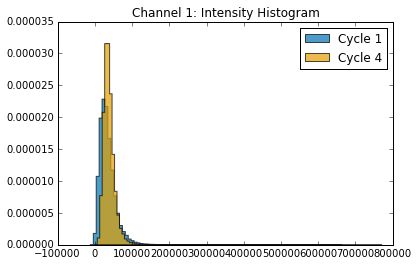

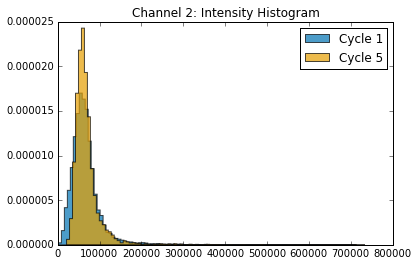

In [4]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.Figure()
ax = fig.add_subplot(1,1,1)

catIntensity_list1 = getIntensityList_category(catDict_ch1)
catIntensity_list2 = getIntensityList_category(catDict_ch2)

intVals_c1 = catIntensity_list1[0][2]
intVals_c2 = catIntensity_list1[3][2]
n1,bins1,patches1 = plt.hist(intVals_c1,bins=100,color='#0072b2',histtype='stepfilled',\
                             normed=True,label='Cycle 1',alpha=0.7)
n2,bins2,patches2 = plt.hist(intVals_c2,bins=100,color='#e69f00',histtype='stepfilled',\
                             normed=True,label='Cycle 4',alpha=0.7)
plt.title('Channel 1: Intensity Histogram')
plt.legend()
plt.show()

intVals_c1 = catIntensity_list2[0][2]
intVals_c2 = catIntensity_list2[5][2]
n1,bins1,patches1 = plt.hist(intVals_c1,bins=100,color='#0072b2',histtype='stepfilled',\
                             normed=True,label='Cycle 1',alpha=0.7)
n2,bins2,patches2 = plt.hist(intVals_c2,bins=100,color='#e69f00',histtype='stepfilled',\
                             normed=True,label='Cycle 5',alpha=0.7)
plt.title('Channel 2: Intensity Histogram')

plt.legend()
plt.show()

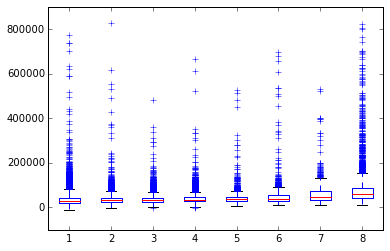

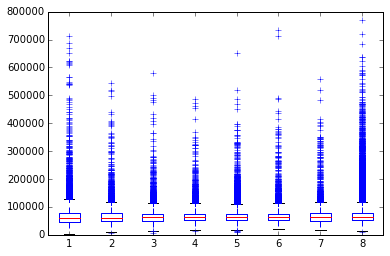

In [5]:
# Plotting intensity values as box plots

catIntensity_list1 = getIntensityList_category(catDict_ch1)
catIntensity_list2 = getIntensityList_category(catDict_ch2)

allData = list()
for category,counts,intensityList in catIntensity_list1:
    allData.append(intensityList)
plt.boxplot(allData,vert=True)
plt.show()

allData = list()
for category,counts,intensityList in catIntensity_list2:
    allData.append(intensityList)
plt.boxplot(allData,vert=True)
plt.show()

51160
8
[51160, 13859, 15486, 39384, 4097, 1417, 1042, 6502]
[14048, 9400, 11907, 11006, 52563, 8092, 4583, 34186]


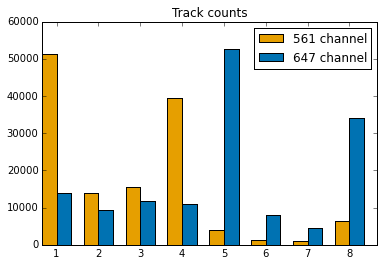

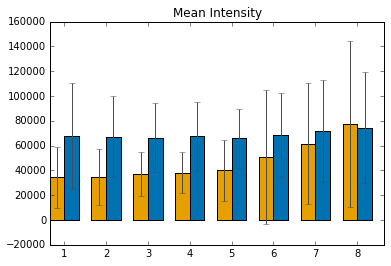

In [11]:
print len(catIntensity_list1[0][2])
print len(catIntensity_list2)
# Plotting the graphs for counts and mean intensities

counts_ch1 = list()
intensity_ch1 = list()
stdev_ch1 = list()

for category,counts,intensityList in catIntensity_list1:
    counts_ch1.append(counts)
    intensity_ch1.append(np.mean(intensityList))
    stdev_ch1.append(np.std(intensityList))

counts_ch2 = list()
intensity_ch2 = list()
stdev_ch2 = list()
for category,counts,intensityList in catIntensity_list2:
    counts_ch2.append(counts)
    intensity_ch2.append(np.mean(intensityList))
    stdev_ch2.append(np.std(intensityList))

print counts_ch1
print counts_ch2

    
n_groups = 8

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

opacity = 1
error_config = {'ecolor': '0.3'}

# For counts
rects1 = plt.bar(index, counts_ch1, bar_width,
                 alpha=opacity,
                 color='#e69f00',
                 label='561 channel')
rects2 = plt.bar(index + bar_width, counts_ch2, bar_width,
                 alpha=opacity,
                 color='#0072b2',
                 label='647 channel')
plt.legend()
plt.title('Track counts')
plt.xticks(index + bar_width, ('1','2','3','4','5','6','7','8'))
plt.show()

# For mean intensity
rects1 = plt.bar(index, intensity_ch1, bar_width,
                 alpha=opacity,
                 color='#e69f00',
                 yerr=stdev_ch1,
                 error_kw=error_config,
                 label='561 channel')
rects2 = plt.bar(index + bar_width, intensity_ch2, bar_width,
                 alpha=opacity,
                 color='#0072b2',
                 yerr=stdev_ch2,
                 error_kw=error_config,
                 label='647 channel')
#plt.legend()
plt.title('Mean Intensity')
plt.xticks(index + bar_width, ('1','2','3','4','5','6','7','8'))
plt.show()

Channel 1 cutoff (25 percentile) 24405.8076275
Channel 2 cutoff (25 percentile) 51109.9286374


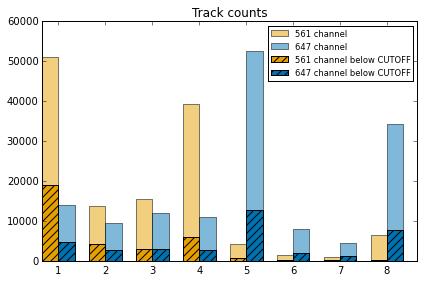

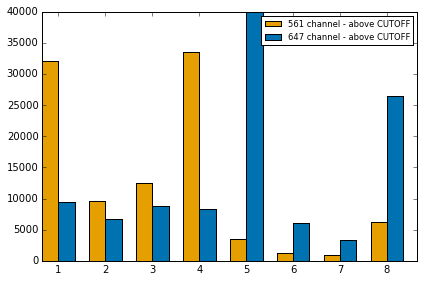

In [14]:
import numpy as np

assert len(catIntensity_list1) == 8
assert len(catIntensity_list2) == 8

allIntensity_ch1 = list()
allIntensity_ch2 = list()
for category,counts,intensityList in catIntensity_list1:
    allIntensity_ch1.extend(intensityList)

for category,counts,intensityList in catIntensity_list2:
    allIntensity_ch2.extend(intensityList)

q1_ch1 = np.percentile(allIntensity_ch1,q=25)
q1_ch2 = np.percentile(allIntensity_ch2,q=25)
print "Channel 1 cutoff (25 percentile)",q1_ch1
print "Channel 2 cutoff (25 percentile)",q1_ch2
    
counts_ch1 = list()
q1Counts_ch1 = list()
nbrCutoff_ch1 = list()
aboveCutoff_ch1 = list()
for category,counts,intensityList in catIntensity_list1:
    less_q1_ch1 = [item for item in intensityList if item < q1_ch1]
    more_q1_ch1 = [item for item in intensityList if item >= q1_ch1]
    nbrCutoff_ch1.append(len(less_q1_ch1))
    aboveCutoff_ch1.append(len(more_q1_ch1))
    counts_ch1.append(counts)

counts_ch2 = list()
q1Counts_ch2 = list()
nbrCutoff_ch2 = list()
aboveCutoff_ch2 = list()
for category,counts,intensityList in catIntensity_list2:
    less_q1_ch2 = [item for item in intensityList if item < q1_ch2]
    more_q1_ch2 = [item for item in intensityList if item >= q1_ch2]
    nbrCutoff_ch2.append(len(less_q1_ch2))
    aboveCutoff_ch2.append(len(more_q1_ch2))
    counts_ch2.append(counts)


# Plotting and overlaying the graphs
n_groups = 8

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35

opacity = 1
error_config = {'ecolor': '0.3'}
# For All counts
rects1 = plt.bar(index, counts_ch1, bar_width,
                 alpha=0.5,
                 color='#e69f00',
                 label='561 channel')
rects2 = plt.bar(index + bar_width, counts_ch2, bar_width,
                 alpha=0.5,
                 color='#0072b2',
                 label='647 channel')

# For cutoff Counts 
rects3 = plt.bar(index, nbrCutoff_ch1, bar_width,
                 alpha=opacity,
                 color='#e69f00',
                 hatch='///',
                 label='561 channel below CUTOFF')
rects4 = plt.bar(index + bar_width, nbrCutoff_ch2, bar_width,
                 alpha=opacity,
                 color='#0072b2',
                 hatch='///',
                 label='647 channel below CUTOFF')
#plt.legend()
plt.title('Track counts')
plt.xticks(index + bar_width, ('1','2','3','4','5','6','7','8'))
plt.legend(fontsize='small')
plt.tight_layout()
plt.show()

# For All counts
rects5 = plt.bar(index, aboveCutoff_ch1, bar_width,
                 alpha=1,
                 color='#e69f00',
                 label='561 channel - above CUTOFF')
rects6 = plt.bar(index + bar_width, aboveCutoff_ch2, bar_width,
                 alpha=1,
                 color='#0072b2',
                 label='647 channel - above CUTOFF')
plt.xticks(index + bar_width, ('1','2','3','4','5','6','7','8'))
plt.legend(fontsize='small')
plt.tight_layout()
plt.show()


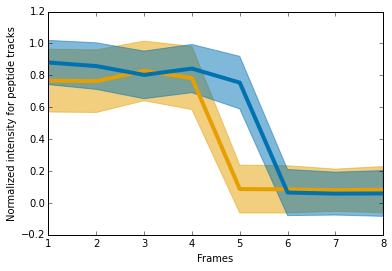

In [179]:
# For the category with the peptides, normalizing it and plotting the intensity across frames (for each track)

category_ch1 = (True, True, True, True, False, False, False, False)
category_ch2 = (True, True, True, True, True, False, False, False)

def normalizeTrackIntensity(l):
    normL = (l-np.min(l))/(np.max(l)-np.min(l))
    return normL
    
allNormList_ch1 = list()
for intensityList in catDict_ch1[category_ch1]:
    normL = normalizeTrackIntensity(intensityList)
    allNormList_ch1.append(normL)
binnedNormList_ch1 = zip(*allNormList_ch1) # This transposes the arrays and bins it according to frames
meanFrame_ch1 = [np.mean(item) for item in binnedNormList_ch1]
stdevFrame_ch1 = [np.std(item) for item in binnedNormList_ch1]

allNormList_ch2 = list()
for intensityList in catDict_ch2[category_ch2]:
    normL = normalizeTrackIntensity(intensityList)
    allNormList_ch2.append(normL)
binnedNormList_ch2 = zip(*allNormList_ch2) # This transposes the arrays and bins it according to frames
meanFrame_ch2 = [np.mean(item) for item in binnedNormList_ch2]
stdevFrame_ch2 = [np.std(item) for item in binnedNormList_ch2]

def getValues(yList,yStd):
    yList = np.array(yList,dtype=float)
    yStd = np.array(yStd)
    yStd_plus = yList + yStd
    yStd_minus = yList - yStd
    return yList,yStd_plus,yStd_minus

# Plotting the line plot with stdev 
n_groups = 8
fig, ax = plt.subplots()
xList = np.arange(n_groups)
yList_ch1,yStd_plus_ch1,yStd_minus_ch1 = getValues(meanFrame_ch1,stdevFrame_ch1)

ax.plot(xList,yList_ch1,color='#e69f00',lw='4')
ax.fill_between(xList,yStd_plus_ch1,yStd_minus_ch1,color='#e69f00',alpha=0.5)

yList_ch2,yStd_plus_ch2,yStd_minus_ch2 = getValues(meanFrame_ch2,stdevFrame_ch2)
ax.plot(xList,yList_ch2,color='#0072b2',lw='4')
ax.fill_between(xList,yStd_plus_ch2,yStd_minus_ch2,color='#0072b2',alpha=0.5)

plt.xticks(index, ('1','2','3','4','5','6','7','8'))
plt.xlabel('Frames')
plt.ylabel('Normalized intensity for peptide tracks')
plt.legend(fontsize='small')
plt.show()

Overall Edman efficiency - Ch1 :  0.518456478413  Ch 2 :  0.601000478226
Mean Edman Efficiency - Ch1 :  0.518509749094  Ch2 :  0.600929927886


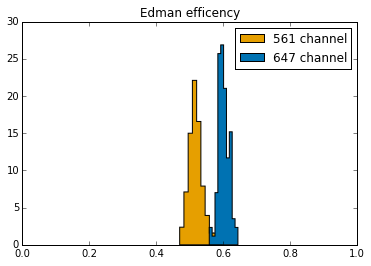

In [222]:
# Calculating Edman efficiency
from __future__ import division

outputDir = '/home/jaggu/marcotte_project/boulgakov/microscope/2015-Oct/2015-10-27_hcomplete/output_2015-11-02'

"""
Total Peptides = Sum(1,2,...8)
Edman Peptides = Counts(Appropriate cycle) i.e tracks cleaved
efficiency = (Total peptides - Edman peptides)/Total peptides
"""
def calculateEfficency(countList,edmanframe):
    edmanCleaved = countList[edmanframe]
    totalPeptides = sum(countList[1:])
    eff = (totalPeptides - edmanCleaved)/totalPeptides
    return eff


edmanframe_ch1 = 3
edmanframe_ch2 = 4
allCounts_ch1 = [item[1] for item in catIntensity_list1]
allCounts_ch2 = [item[1] for item in catIntensity_list2]

eff_ch1 = calculateEfficency(allCounts_ch1,edmanframe_ch1)
eff_ch2 = calculateEfficency(allCounts_ch2,edmanframe_ch2)

print "Overall Edman efficiency - Ch1 : ",eff_ch1," Ch 2 : ",eff_ch2


"""
Heat map of Edman efficiency for each frame;
It is 100 fields - 10 rows x 10 columns
Will create an array - For each field idx (0..100), I need to get (a) the array (i,j), 
(b) (category1,..), (c) (counts1,..)
""" 

fname = os.path.join(outputDir,'category_counts_nx8t5v.csv')
ifile = open(fname,'r')
lines = ifile.readlines()[1:]
ifile.close()

fld_counts_dict_ch1 = collections.defaultdict(list)
fld_counts_dict_ch2 = collections.defaultdict(list)

for line in lines:
    category, fld, ch, counts = line.strip().split(',')
    fld,counts = map(int,[fld,counts])
    if ch == 'ch1': 
        fld_counts_dict_ch1[fld].append(counts) # The category, counts are appended due to the already sorted
    if ch == 'ch2':
        fld_counts_dict_ch2[fld].append(counts)

allefficency_ch1 = list()
fld_efficency_ch1 = list()
allefficency_ch2 = list()
fld_efficency_ch2 = list()
for fld, l in fld_counts_dict_ch1.items():
    eff = calculateEfficency(l,edmanframe_ch1)
    fld_efficency_ch1.append((fld,eff))
    allefficency_ch1.append(eff)

for fld, l in fld_counts_dict_ch2.items():
    eff = calculateEfficency(l,edmanframe_ch2)
    fld_efficency_ch2.append((fld,eff))
    allefficency_ch2.append(eff)

print "Mean Edman Efficiency - Ch1 : ",np.mean(allefficency_ch1), " Ch2 : ",np.mean(allefficency_ch2)

# Plot histogram of efficency
fig = plt.Figure()
ax = fig.add_subplot(1,1,1)

n1,bins1,patches1 = plt.hist(allefficency_ch1,bins=10,color='#e69f00',histtype='stepfilled',\
                             normed=True,label='561 channel',alpha=1)
n2,bins2,patches2 = plt.hist(allefficency_ch2,bins=10,color='#0072b2',histtype='stepfilled',\
                             normed=True,label='647 channel',alpha=1)
plt.title('Edman efficency')
plt.xlim([0,1])
plt.legend()
plt.show()    

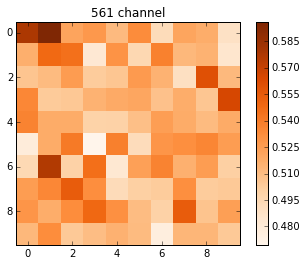

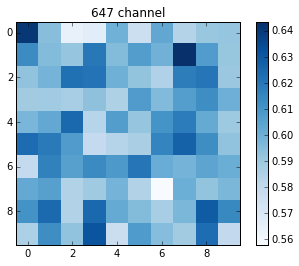

In [268]:
# Making a heat map of Edman efficency; The fields are arranged by snaking around 10 cols x 10 rows

def assignRowCol_Files(nbr_fileList,rows=10,cols=10):
        # rows - 0,2,4,... assigned from left to right, and odd 1,3,5... rows assigned right to left; 
        # It is a snaking grid
        r, c = 0, 0
        flag = 'right'
        cell_fname_list = list()
        for nbr,f in nbr_fileList:
                if flag == 'right':
                        if c == 0: 
                                cell_fname_list.append([(r,c),nbr, f])
                                c+=1
                        elif c == (cols-1): 
                                cell_fname_list.append([(r,c),nbr, f])                       
                                r+=1
                                flag = 'left'
                        else:
                                cell_fname_list.append([(r,c),nbr, f])       
                                c+=1
                elif flag == 'left':
                        if c == 0 :
                                cell_fname_list.append([(r,c),nbr, f])
                                flag = 'right'
                                r+=1
                        else:
                                cell_fname_list.append([(r,c),nbr, f])
                                c -=1                   
                else:print flag 
        return cell_fname_list

cells_ch1 = assignRowCol_Files(fld_efficency_ch1)
cells_ch2 = assignRowCol_Files(fld_efficency_ch2)

# Heat map
data_ch1 = np.zeros((10,10),dtype=float)
for pos,nbr, eff in cells_ch1: data_ch1[pos]=eff

im = plt.imshow(data_ch1,interpolation='nearest', cmap='Oranges')
plt.colorbar(im,orientation='vertical')
plt.title('561 channel')
plt.show()

data_ch2 = np.zeros((10,10),dtype=float)
for pos,nbr, eff in cells_ch2: data_ch2[pos]=eff

im = plt.imshow(data_ch2,interpolation='nearest', cmap='Blues')
plt.colorbar(im,orientation='vertical')
plt.title('647 channel')
plt.show()